<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2022</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

*   Задача: Предсказание оттока пользователей
*   Ник на kaggle (в лидерборде): Юлия_Зарипова
*   Ссылка на профиль на kaggle:
[www.kaggle.com/yuliazaripova](https://www.kaggle.com/yuliazaripova)
*   Результат с kaggle (score): 0.84584

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсутствующий пункт из рекомендации снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров другого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [4]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
# Импорт необходимых библиотек

! pip install catboost

import pandas as pd
import numpy as np
import catboost 
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [93]:
# Загружаем обучающую выборку

train_data = pd.read_csv('./train.csv')

In [94]:
# Загружаем тестовую выборку

test_data = pd.read_csv('./test.csv')

In [7]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [89]:
# Смотрим на случайные 10 строк в обучающей выборке

train_data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3462,4,80.25,303.70,Female,1,No,No,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,0
2080,1,71.65,71.65,Male,0,No,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
5240,65,95.45,6223.30,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0
4199,2,19.40,50.60,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
2207,10,40.70,449.30,Female,0,No,No,No,No phone service,DSL,Yes,Yes,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),0
1442,24,20.40,482.80,Female,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0
3165,10,80.70,788.80,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
1626,53,90.80,4921.20,Female,0,No,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,Month-to-month,No,Electronic check,0
1261,7,40.10,293.30,Female,0,No,No,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),1
2077,55,20.50,1177.95,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0


In [90]:
# Смотрим на случайные 10 строк в тестовой выборке

test_data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
706,1,20.35,20.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
114,71,25.45,1789.65,Male,1,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
1723,31,25.75,755.60,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1573,66,62.50,4136.40,Female,0,No,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic)
541,5,84.70,392.50,Female,1,No,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check
1540,3,19.60,61.35,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1294,24,39.10,971.30,Male,1,Yes,No,No,No phone service,DSL,Yes,No,No,No,No,Yes,Month-to-month,No,Bank transfer (automatic)
1502,62,20.45,1297.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
1034,20,20.00,417.65,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check
958,71,114.00,8175.90,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic)


In [95]:
# Смотрим, есть ли в обучающей выборке незаполненные значения (nan'ы)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [96]:
# Смотрим, есть ли в тестовой выборке незаполненные значения (nan'ы)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Незаполненных значений нет, но TotalSpent содержит значения типа object, что для числовых признаков недопустимо. Нужно перевести его в числовое значение. 

In [23]:
# Переводим TotalSpent в числовые значения, при этом ставя на месте NaN нули

train_data["TotalSpent"] = pd.to_numeric(train_data["TotalSpent"], errors='coerce').fillna(0)
test_data["TotalSpent"] = pd.to_numeric(test_data["TotalSpent"], errors='coerce').fillna(0)

После преобразования ещё разок проверим на наличие NaN

In [80]:
# Строим для обучающей выборки табличку с количеством nan в каждой колонке

train_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [81]:
# Строим для тестовой выборки табличку с количеством nan в каждой колонке

test_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

## Анализ данных (3 балла)

1) Для численных признаков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, если вы сможете это сделать на одном графике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3c1609650>,
      dtype=object)

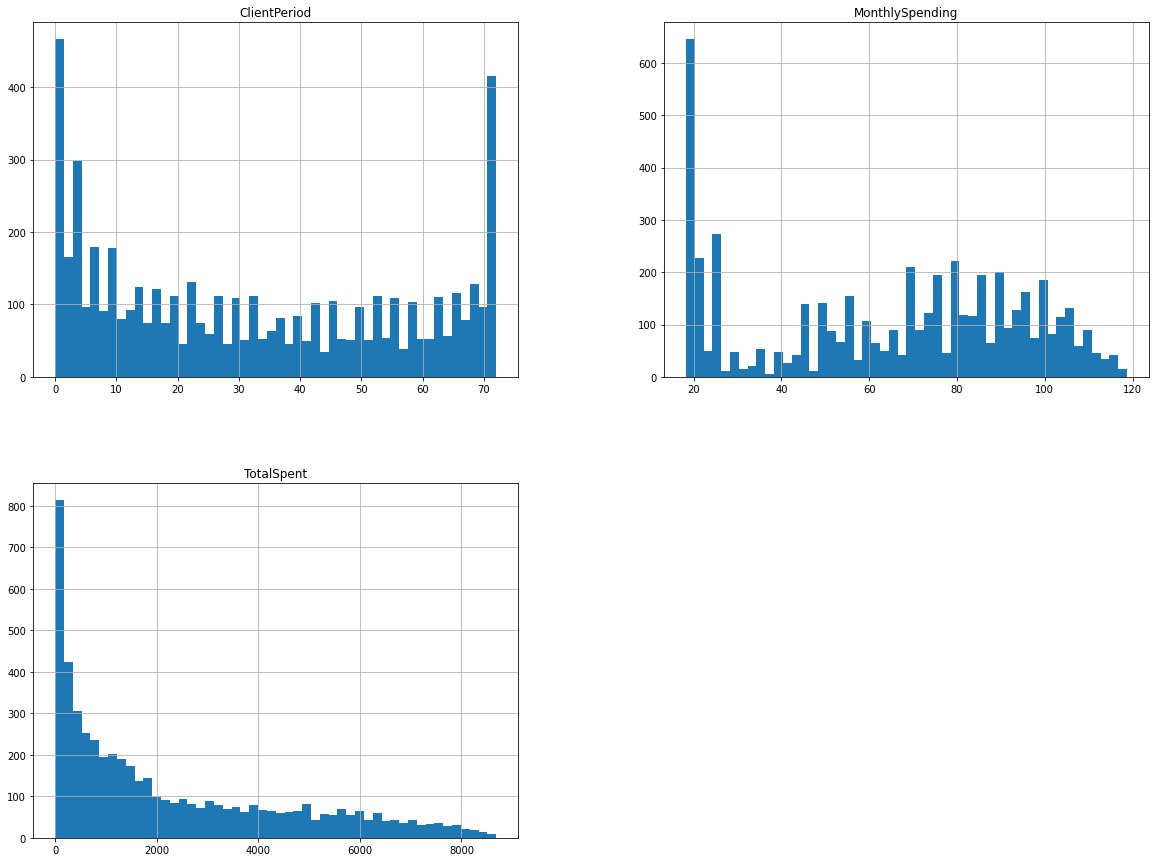

In [70]:
# Строим гистограммы для численных признаков

train_data[num_cols].hist(bins = 50, figsize = (20, 15))

In [86]:
# Считаем value_counts для категориальных признаков

for id, col in enumerate(cat_cols):
    print(train_data[col].value_counts())
    print('\n')

Male      2655
Female    2627
Name: Sex, dtype: int64


0    4440
1     842
Name: IsSeniorCitizen, dtype: int64


No     2705
Yes    2577
Name: HasPartner, dtype: int64


No     3676
Yes    1606
Name: HasChild, dtype: int64


Yes    4761
No      521
Name: HasPhoneService, dtype: int64


No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64


No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64


No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess,

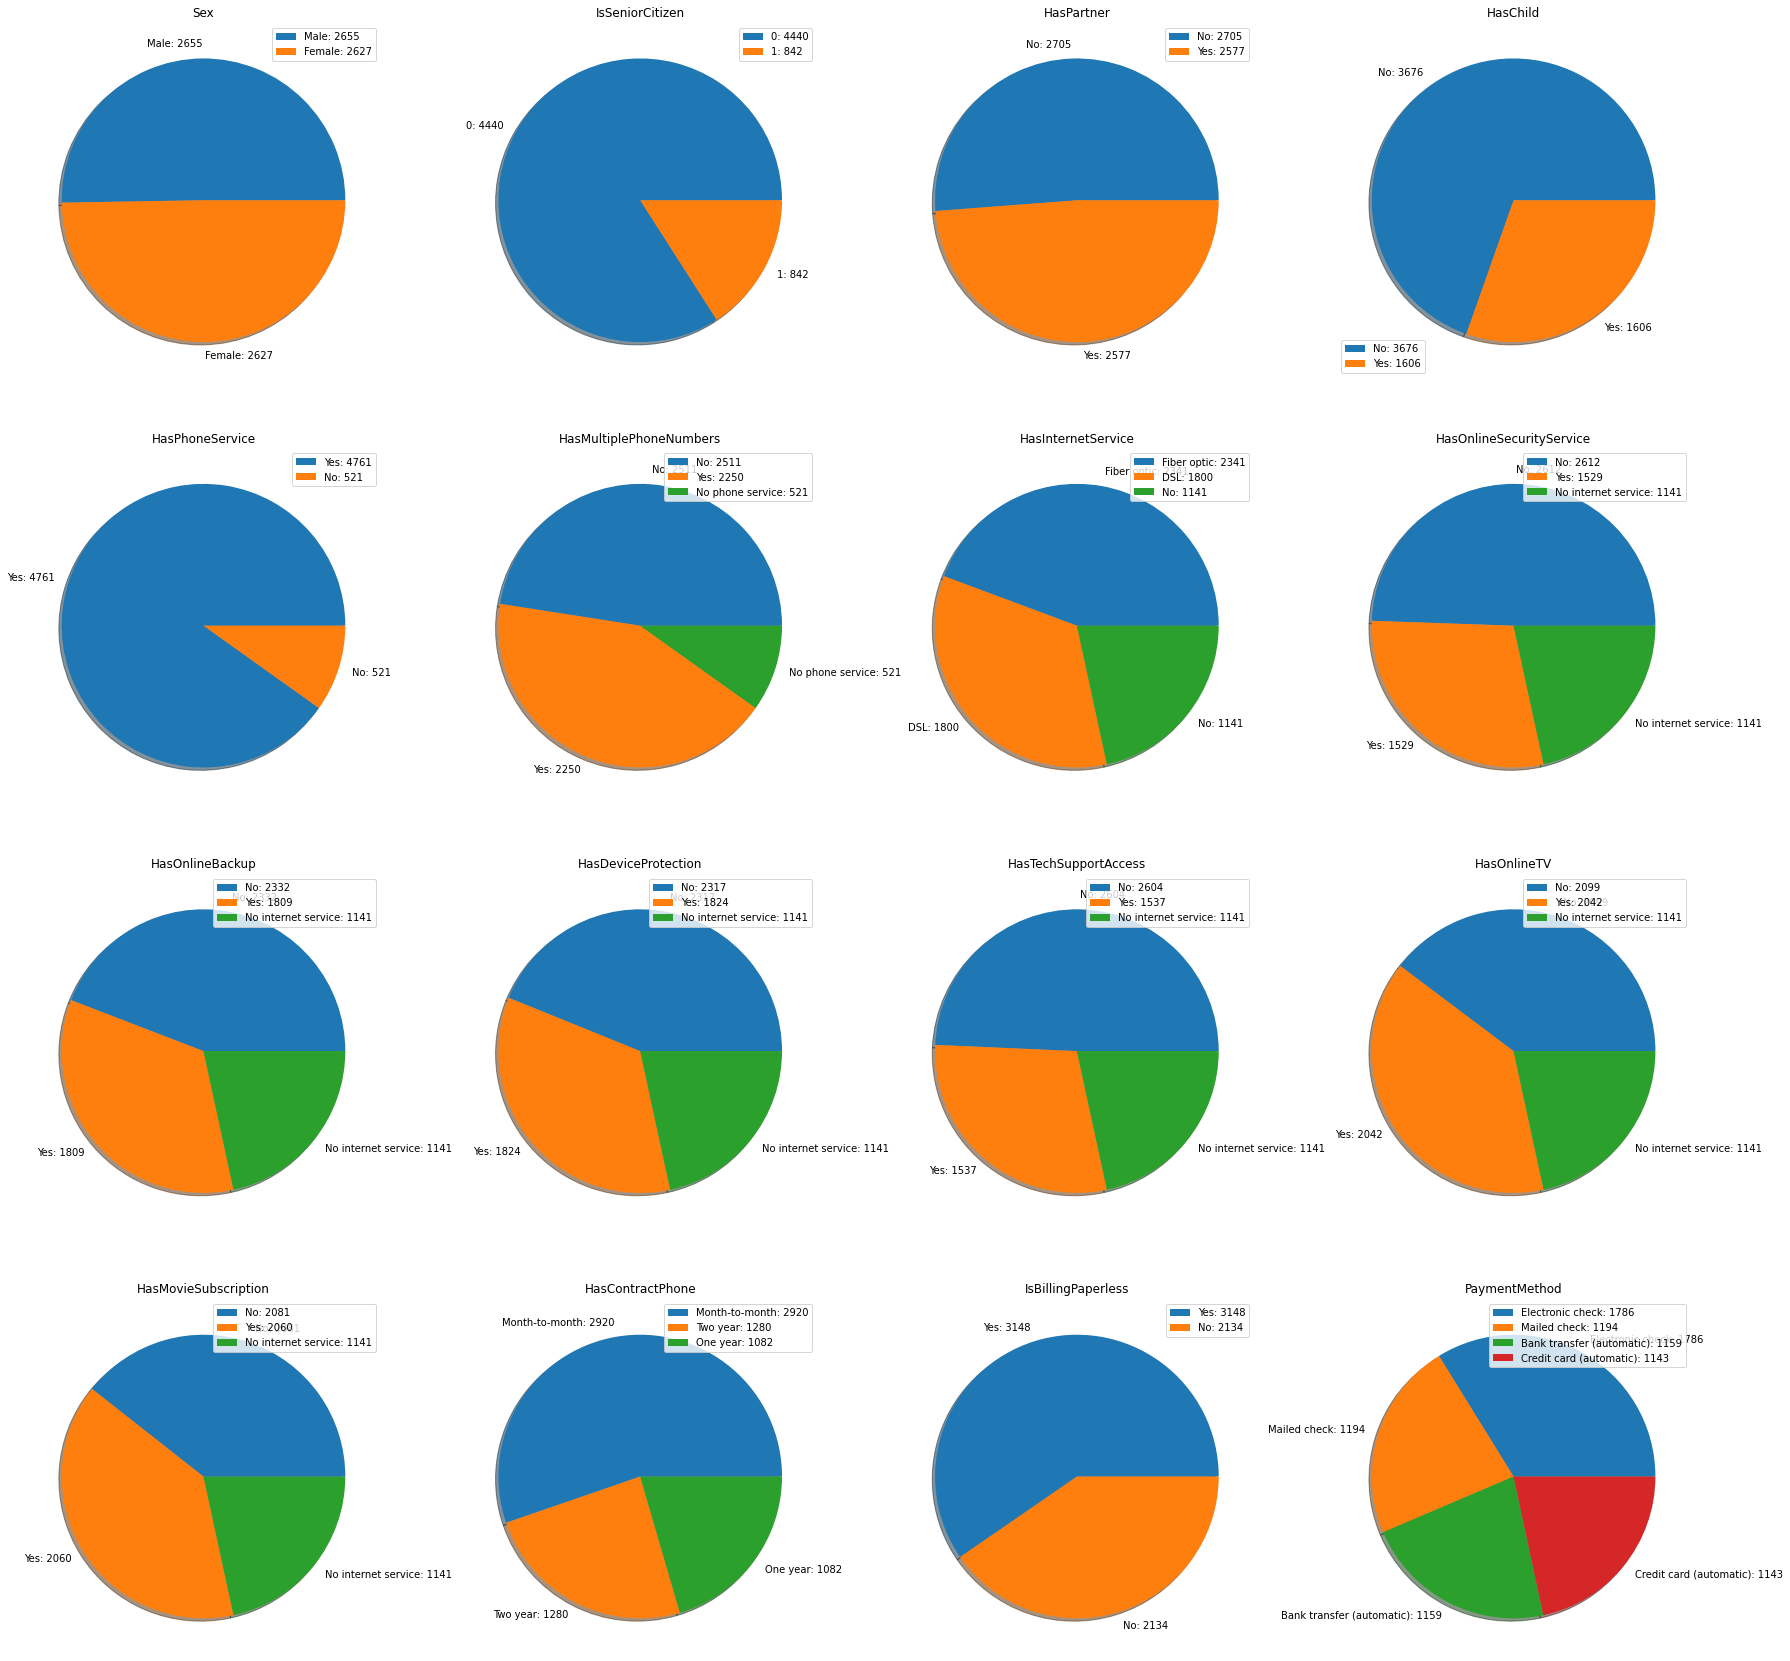

In [47]:
#Строим круговые диаграммы для категориальных признаков 

plt.figure(figsize = (30, 30))
for id, col in enumerate(cat_cols):
    ax = plt.subplot(4, 4, id + 1)
    plot_data = train_data[col].value_counts().to_numpy()
    plot_labels = (train_data[col].value_counts().index).astype(str) + ': ' + plot_data.astype(str)
    plt.pie(plot_data, labels = plot_labels, shadow = True)
    plt.title(col)
    plt.legend()

In [48]:
# Смотрим на распределение целевой переменной

train_data.Churn.value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

([<matplotlib.patches.Wedge at 0x7f0091d5aa50>,
 [Text(-0.7478930722742168, 0.8066324766857789, '0: 3898'),
  Text(0.7478930722742166, -0.8066324766857789, '1: 1384')])

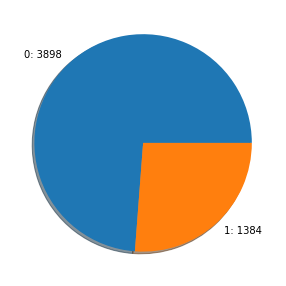

In [29]:
plt.figure(figsize = (5, 5))
plot_data = train_data.Churn.value_counts().to_numpy()
plot_labels = (train_data.Churn.value_counts().index).astype(str) + ': ' + plot_data.astype(str)
plt.pie(plot_data, labels = plot_labels, shadow = True)

Мы видим, что классы несбалансированы.

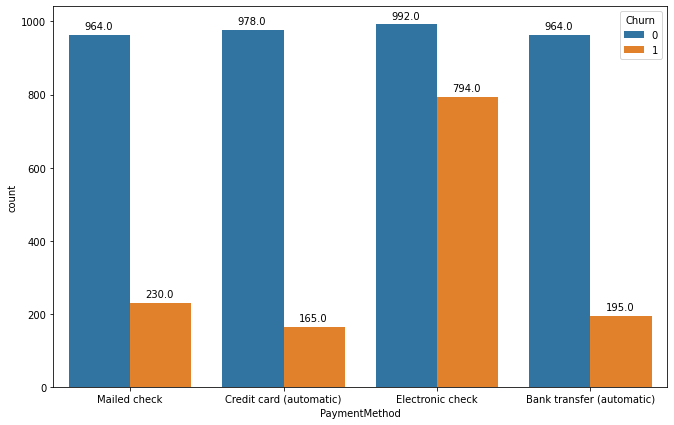

In [39]:
# При помощи sns посмотрим на количественное распределение целевой переменной в зависимости от признака PaymentMethod

fig, ax = plt.subplots(figsize = (11,7))
ax = sns.countplot(x = "PaymentMethod", data = train_data, hue = "Churn")
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 15))

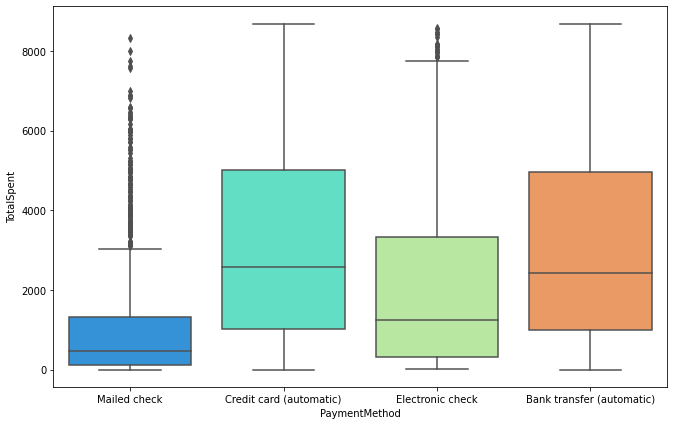

In [46]:
# При помощи sns посмотрим на диаграммы размаха TotalSpent для разных значений PaymentMethod

fig, ax = plt.subplots(figsize = (11,7))
ax = sns.boxplot(x = "PaymentMethod", y = "TotalSpent", data = train_data, palette = 'rainbow')

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно использовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа превращаем в one-hot вектора.)

In [54]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [68]:
# Отделяем признаки от целевой переменной

X, y = train_data[feature_cols], train_data[target_col]

# Делим выборку на обучающую и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [52]:
# Нормирование числовых признаков и кодирование категориальных производится при помощи ColumnTransformer

ct = ColumnTransformer(
    [("num", make_pipeline(StandardScaler(), MinMaxScaler()), num_cols),
    ("col", OneHotEncoder(), cat_cols)]
)

# Соединяем преобразования данных и LogisticRegression в один Pipeline

pipeline__ = make_pipeline(ct, LogisticRegression(max_iter = 500))

In [53]:
# Передаем pipeline в GridSearchCV и используем кроссвалидацию

gs = GridSearchCV(pipeline__, param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.01, 0.001]}, scoring = 'roc_auc', refit = True)

In [ ]:
gs.fit(X, y)

In [ ]:
pd.DataFrame(gs.cv_results_)

In [57]:
print("Лучшее значение ROC-AUC: {0} получено при C = {1}".format(round(gs.best_score_, 5), gs.best_params_['logisticregression__C']))

Лучшее значение ROC-AUC: 0.84511 получено при C = 100


Дополнительно протестируем алгоритм Random forest ("случайный лес") 

In [69]:
# Соединяем преобразования данных и RandomForestClassifier в один Pipeline

pipeline__ = make_pipeline(ct, RandomForestClassifier())

# Обучаем модель

pipeline__.fit(X_train, y_train)

# Вычисляем предсказания

prediction = pipeline__.predict_proba(X_test)

In [72]:
print("Значение ROC-AUC при применении RandomForestClassifier: {0}".format(round(roc_auc_score(y_test, prediction[:, 1]), 5)))

Значение ROC-AUC при применении RandomForestClassifier: 0.7947


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные значения параметров количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [73]:
# Делим выборку на train/valid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [74]:
# Тестируем catboost cо стандартными параметрами

classifier = CatBoostClassifier(verbose = False, cat_features = cat_cols)
classifier.fit(X_train, y_train)

In [87]:
# Вычисляем предсказания 

prediction = classifier.predict_proba(X_test)

In [88]:
print("Значение ROC-AUC при применении CatBoostClassifier со стандартными параметрами: {0}".
      format(round(roc_auc_score(y_test, prediction[:, 1]), 5)))

Значение ROC-AUC при применении CatBoostClassifier со стандартными параметрами: 0.82339


In [63]:
# Тестируем разные значения параметров количества деревьев и learning_rate'а (на колабе продолжительность вычислений около 10-11 минут)

params = {
    'num_trees' : [],
    'lr' : [],
    'score_test' : []
}

num_trees = np.arange(50, 350, 50)
lr = np.arange(0.01, 0.51, 0.01)

for trees in num_trees:
    for rate in lr: 
        catboost_classifier = CatBoostClassifier(cat_features = cat_cols, 
                                                verbose = False, 
                                                n_estimators = trees, 
                                                learning_rate = rate)
            
        catboost_classifier.fit(X_train, y_train)
        prediction = catboost_classifier.predict_proba(X_test)

        params['num_trees'].append(trees)
        params['lr'].append(rate)
        params['score_test'].append(roc_auc_score(y_test, prediction[:, 1]))

In [82]:
display(pd.DataFrame(params).sort_values('score_test', ascending = False).head(10))

,num_trees,lr,score_test
252,300,0.03,0.831254
202,250,0.03,0.830594
152,200,0.03,0.829869
251,300,0.02,0.829839
201,250,0.02,0.829261
203,250,0.04,0.829238
153,200,0.04,0.829026
61,100,0.12,0.828857
154,200,0.05,0.828853
250,300,0.01,0.828483


Таким образом, лучшее качество roc_auc = 0.831254, получено при lr = 0.03 и количестве деревьев = 300

# Предсказания

In [130]:
# Лучшей моделью оказалась логистическая регрессия: ROC-AUC = 0.84511

best_model = gs.best_estimator_

In [143]:
# Вычисляем предсказания и выгружаем их в файл

submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(test_data)[:, 1]
submission.to_csv('./my_submission.csv', index = False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.